In [1]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.2/38.2 MB 6.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.1
    Uninstalling scipy-1.16.1:
      Successfully uninstalled scipy-1.16.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.

In [3]:
!pip install pyLDAvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 27.5 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import gensim
from gensim import corpora
from gensim.models import LdaModel, CoherenceModel
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from gensim.corpora import Dictionary
import pyLDAvis
import pyLDAvis.gensim_models
from gensim.models import Word2Vec

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import nltk
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
import re
import collections
from collections import Counter

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Import data

In [ ]:
df_hanoi = pd.read_csv('clean_hanoi.csv')
df_danang = pd.read_csv('clean_danang.csv')
df_vn = pd.concat([df_hanoi, df_danang], ignore_index=True)
df_vn.head()

,rating,date,travel_type,location,content,processed_text
0,4.0,2025-07,Friends,NaN,"Hà Nội We are really like here with good food,...",hà nội really like good food nice people frien...
1,5.0,2025-07,Couples,Australia,Great thing to do in Hanoi What a great thing ...,great thing hanoi great thing hanoi bella grea...
2,5.0,2025-07,NaN,NaN,The teacher was bright and had a lot of fun. T...,teacher bright lot fun food together meal grea...
3,5.0,2025-07,Friends,Singapore,Friendly and Happy Experience The class timing...,friendly happy experience class timing perfect...
4,5.0,2025-07,NaN,NaN,We had an absolutely amazing time at this cook...,absolutely amazing time cooking class sunny in...


In [ ]:
df_bangkok = pd.read_csv('clean_bangkok.csv')
df_pattaya = pd.read_csv('clean_pattaya.csv')
df_tl = pd.concat([df_bangkok, df_pattaya], ignore_index=True)
df_tl.head()

,rating,date,travel_type,location,content,processed_text
0,5,2025-07,Couples,NaN,Great tour Anna was a great tour guide. Alot o...,great tour anna great tour guide alot fun saw ...
1,5,2025-07,Family,NaN,"Boat tour Excellent excursion, very fun. Ken, ...",boat tour excellent excursion fun ken attentiv...
2,5,2025-07,Family,NaN,Thon buri canal trip Great insight into Thon B...,thon buri canal trip great insight thon buri c...
3,5,2025-07,Friends,NaN,"Great Tour Great guide, showed us lots of inte...",great tour great guide showed u lot interestin...
4,5,2025-07,Solo,NaN,Must do. It was a great experience. I would de...,must great experience would definitely guide f...


**VN Topic Modelling**

Bigram-Model

Preprocessing

In [ ]:
#Tokenize and reclean

nltk_stopwords = set(stopwords.words('english'))
custom_stopwords = {'u', 'hanoi', 'vietnam', 'really', 'would', 'also', 'made', 'well', 'lot', 'great', 'amazing', 'good', 'best', 'nice', 'much', 'excellent', 'fun', 'beautiful', 'wonderful', 'fantastic', 'one', 'thank', 'visit', 'go', 'get', 'day', 'perfect', 'went', 'take'}
final_stopwords = nltk_stopwords.union(custom_stopwords)

def tokenize_text(text):
    words = word_tokenize(str(text))
    return [word for word in words if word not in final_stopwords]

df_vn['tokens'] = df_vn['processed_text'].apply(tokenize_text)

# Build bigram model
bigram_model = Phrases(df_vn['tokens'], min_count=5, threshold=5)  # tweak these for sensitivity
bigram_phraser = Phraser(bigram_model)

# Apply bigram transformation
df_vn['tokens_bigrams'] = df_vn['tokens'].apply(lambda x: bigram_phraser[x])

In [ ]:
all_bigrams = []
for tokens in df_vn['tokens_bigrams']:
    all_bigrams.extend([token for token in tokens if '_' in token])

bigram_counts = Counter(all_bigrams)
print(bigram_counts.most_common(20))

[('tour_guide', 7980), ('highly_recommend', 6580), ('halong_bay', 2576), ('ha_long', 2348), ('cooking_class', 2112), ('highly_recommended', 1964), ('definitely_recommend', 1911), ('ninh_binh', 1769), ('old_quarter', 1546), ('da_nang', 1368), ('street_food', 1073), ('food_delicious', 903), ('staff_friendly', 891), ('ba_na', 814), ('come_back', 804), ('train_street', 758), ('walking_tour', 684), ('ho_chi', 680), ('cable_car', 674), ('make_sure', 667)]


In [ ]:
# Bag of Words Analysis
def bag_of_words_analysis(texts):
    """
    This function performs Bag of Words analysis and plots the top 20 frequent words.
    """
    word_counts = Counter()
    word_counts.update(texts.split(' '))

    most_common = word_counts.most_common(20)
    print(word_counts)
    words, counts = zip(*most_common)

    # Plotting
    plt.bar(words, counts)
    plt.title("Top 20 Most Frequent Words")
    plt.show()

    return most_common

Counter({'tour': 22647, 'experience': 19859, 'food': 13321, 'trip': 11431, 'time': 10921, 'guide': 10848, 'massage': 10168, 'tour_guide': 7980, 'place': 7867, 'highly_recommend': 6580, 'service': 6126, 'recommend': 5823, 'friendly': 4801, 'cruise': 4448, 'staff': 3662, 'lovely': 3345, 'everything': 3305, 'view': 3280, 'boat': 3279, 'helpful': 3067, 'local': 3029, 'people': 2930, 'enjoyed': 2870, 'got': 2709, 'way': 2677, 'bay': 2648, 'spa': 2633, 'took': 2626, 'like': 2621, 'even': 2608, 'halong_bay': 2576, 'see': 2567, 'hoi': 2538, 'city': 2487, 'activity': 2474, 'many': 2417, 'knowledgeable': 2416, 'super': 2362, 'ha_long': 2348, 'kind': 2307, 'back': 2302, 'night': 2261, 'professional': 2227, 'around': 2211, 'awesome': 2205, 'happy': 2185, 'informative': 2173, 'thanks': 2171, 'relaxing': 2164, 'incredible': 2123, 'must': 2115, 'cooking_class': 2112, 'area': 2098, 'history': 2073, 'interesting': 2020, 'highly_recommended': 1964, 'worth': 1932, 'family': 1929, 'definitely_recommend': 

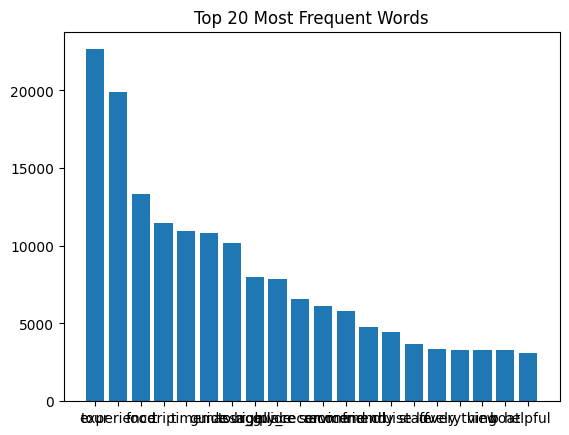

[('tour', 22647),
 ('experience', 19859),
 ('food', 13321),
 ('trip', 11431),
 ('time', 10921),
 ('guide', 10848),
 ('massage', 10168),
 ('tour_guide', 7980),
 ('place', 7867),
 ('highly_recommend', 6580),
 ('service', 6126),
 ('recommend', 5823),
 ('friendly', 4801),
 ('cruise', 4448),
 ('staff', 3662),
 ('lovely', 3345),
 ('everything', 3305),
 ('view', 3280),
 ('boat', 3279),
 ('helpful', 3067)]

In [ ]:
# Combine all tokens into one list
all_tokens = [token for sublist in df_vn['tokens_bigrams'] for token in sublist]

# Convert to space-separated string for analysis
all_words = ' '.join(all_tokens)
bag_of_words_analysis(all_words)

In [ ]:
# TF-IDF Analysis
def tf_idf_analysis(texts, top_n=20):
    vectorizer = TfidfVectorizer(stop_words=list(final_stopwords))
    tfidf_matrix = vectorizer.fit_transform([texts])
    feature_array = np.array(vectorizer.get_feature_names_out())

    # Dictionary to keep track of words and their corresponding scores
    max_tfidf_dict = {}
    for i in range(tfidf_matrix.shape[0]):
        row = tfidf_matrix.getrow(i)
        for word, score in zip(row.indices, row.data):
            feature_word = feature_array[word]
            max_tfidf_dict[feature_word] = max(max_tfidf_dict.get(feature_word, 0), score)

    # Sort words by their score and get top n
    sorted_words = sorted(max_tfidf_dict.items(), key=lambda item: item[1], reverse=True)[:top_n]
    words, scores = zip(*sorted_words)

    return words, scores

# Combine all tokens (cleaned) into one string
all_tokens = [token for sublist in df_vn['tokens_bigrams'] for token in sublist]
all_words = ' '.join(all_tokens)

# Conduct TF-IDF analysis
top_words, top_scores = tf_idf_analysis(all_words)

# Print the top 20 common words
print("Top 20 common words and their TF-IDF scores:")
for word, score in zip(top_words, top_scores):
    print(f"{word}: {score:.4f}")

Top 20 common words and their TF-IDF scores:
tour: 0.4553
experience: 0.3992
food: 0.2678
trip: 0.2298
time: 0.2195
guide: 0.2181
massage: 0.2044
tour_guide: 0.1604
place: 0.1581
highly_recommend: 0.1323
service: 0.1232
recommend: 0.1171
friendly: 0.0965
cruise: 0.0894
staff: 0.0736
lovely: 0.0672
everything: 0.0664
view: 0.0659
boat: 0.0659
helpful: 0.0617


LDA Training

In [ ]:
#Coherence score by number of topics

tokenized_texts = df_vn['tokens_bigrams'].tolist()

dictionary_vn = Dictionary(df_vn['tokens_bigrams'])
dictionary_vn.filter_extremes(no_below=5, no_above=0.5)
corpus_vn = [dictionary_vn.doc2bow(text) for text in df_vn['tokens_bigrams']]

def compute_coherence_values(dictionary, corpus, texts, topic_range):
    coherence_scores = []
    for num_topics in topic_range:
        lda_model = gensim.models.LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics,
            random_state=42,
            passes=10,
            iterations=200
        )
        coherence_model = CoherenceModel(
            model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v'
        )
        coherence_score = coherence_model.get_coherence()
        coherence_scores.append(coherence_score)
        print(f"Num Topics: {num_topics}, Coherence Score: {coherence_score:.4f}")

    return coherence_scores

topic_range = range(2, 20)

coherence_scores = compute_coherence_values(dictionary_vn, corpus_vn, tokenized_texts, topic_range)

plt.figure(figsize=(8, 5))
plt.plot(topic_range, coherence_scores, marker='o', linestyle='-')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Score vs. Number of Topics")
plt.grid()
plt.show()

optimal_topic_num = topic_range[coherence_scores.index(max(coherence_scores))]
print(f"Optimal Number of Topics: {optimal_topic_num}")

In [ ]:
dictionary_vn = Dictionary(df_vn['tokens_bigrams'])
dictionary_vn.filter_extremes(no_below=5, no_above=0.5)
corpus_vn = [dictionary_vn.doc2bow(text) for text in df_vn['tokens_bigrams']]

#Train LDA model
lda_model_vn_7 = LdaModel(
    corpus=corpus_vn,
    id2word=dictionary_vn,
    num_topics=7,
    random_state=42,
    passes=10,
    iterations=200,
    alpha='auto',
    eta='auto',
    minimum_probability=0.01
)

# Print output LDA topics with top 20 keywords
print("\n=== LDA Topics ===")
for topic_id, words in lda_model_vn_7.show_topics(num_topics=7, num_words=20, formatted=False):
    print(f"Topic {topic_id}: {[word for word, _ in words]}")


=== LDA Topics ===
Topic 0: ['food', 'experience', 'cooking_class', 'delicious', 'market', 'vietnamese', 'try', 'class', 'cooking', 'restaurant', 'dish', 'local', 'street_food', 'tried', 'eat', 'home', 'make', 'dao', 'authentic', 'coffee']
Topic 1: ['cable_car', 'show', 'golden_bridge', 'see', 'museum', 'building', 'think', 'beach', 'pretty', 'garden', 'lantern', 'quite', 'water', 'impressive', 'kid', 'ticket', 'theme_park', 'however', 'fabric', 'still']
Topic 2: ['place', 'time', 'hoi', 'da_nang', 'way', 'area', 'see', 'bridge', 'worth', 'around', 'many', 'city', 'people', 'even', 'must', 'view', 'ride', 'photo', 'interesting', 'visited']
Topic 3: ['massage', 'service', 'experience', 'spa', 'professional', 'suit', 'relaxing', 'tailor', 'staff', 'got', 'hoi', 'ba_na', 'quality', 'clean', 'recommend', 'come', 'back', 'danang', 'highly_recommend', 'place']
Topic 4: ['trip', 'experience', 'time', 'hill', 'helpful', 'beach', 'view', 'boat', 'cruise', 'friendly', 'family', 'activity', 'eve

Evaluation

In [ ]:
#Coherence score
coherence_model_lda = CoherenceModel(
    model=lda_model_vn_7, texts=df_vn['tokens_bigrams'], dictionary=dictionary_vn, coherence='c_v'
)
coherence_lda = coherence_model_lda.get_coherence()

print(f"LDA Coherence Score: {coherence_lda:.3f}")

LDA Coherence Score: 0.478


In [ ]:
# LDA diversity
def calculate_lda_topic_diversity(lda_model, top_n_words=20):
    topics = lda_model.show_topics(num_topics=lda_model.num_topics, num_words=top_n_words, formatted=False)
    unique_words = set()
    for topic in topics:
        unique_words.update([word for word, _ in topic[1]])
    num_unique_words = len(unique_words)
    total_words_considered = top_n_words * lda_model.num_topics
    print(f"Number of unique words: {num_unique_words}")
    print(f"Total words considered: {total_words_considered}")
    return num_unique_words / total_words_considered

lda_topic_diversity = calculate_lda_topic_diversity(lda_model_vn_7)

print(f"LDA Topic Diversity Score: {lda_topic_diversity:.3f}")

Number of unique words: 119
Total words considered: 140
LDA Topic Diversity Score: 0.850


In [ ]:
dictionary_tweet = corpora.Dictionary(df_vn['tokens_bigrams'])
dictionary_tweet.filter_extremes(no_below=5, no_above=0.5)
corpus_tweet = [dictionary_tweet.doc2bow(text) for text in df_vn['tokens_bigrams']]

num_topics = 7
lda_model = gensim.models.LdaModel(
    corpus=corpus_tweet,
    id2word=dictionary_tweet,
    num_topics=num_topics,
    random_state=42,
    passes=10,
    iterations=200
)
pyLDAvis.enable_notebook(local=True)

vis = pyLDAvis.gensim_models.prepare(lda_model, corpus_tweet, dictionary_tweet)

vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.077189  0.269779       1        1  18.605715
5     -0.180687 -0.115707       2        1  16.522099
2      0.160208 -0.153048       3        1  14.900653
4     -0.225102  0.009387       4        1  13.707032
6      0.216550  0.110465       5        1  12.242425
0     -0.130133 -0.085127       6        1  12.053219
1      0.236354 -0.035749       7        1  11.968856, topic_info=         Term          Freq         Total Category  logprob  loglift
202      tour  17858.000000  17858.000000  Default  30.0000  30.0000
452   massage  11151.000000  11151.000000  Default  29.0000  29.0000
36       trip  11138.000000  11138.000000  Default  28.0000  28.0000
0        food   8896.000000   8896.000000  Default  27.0000  27.0000
126     guide   8915.000000   8915.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
44       time   1011.736860  11361.537174   Topic7  -4.8025  -0.2957
4        like    656.213186   2732.376858   Topic7  -5.2354   0.6964
1100   better    503.309855   1293.716465   Topic7  -5.5007   1.1788
343      even    543.173850   2543.444223   Topic7  -5.4245   0.5790
189      hour    479.882858   1484.764493   Topic7  -5.5483   0.9934

[434 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
5282      2  0.997239    access
282       2  0.130543  activity
282       3  0.004835  activity
282       4  0.864375  activity
2067      3  0.996703  addition
...     ...       ...       ...
289       3  0.327664     worth
289       4  0.052366     worth
289       5  0.176550     worth
289       6  0.031919     worth
289       7  0.312204     worth

[702 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 6, 3, 5, 7, 1, 2])

**THAILAND Topic Modeling**

Preprocessing

In [ ]:
#Tokenize and reclean

nltk_stopwords = set(stopwords.words('english'))
custom_stopwords = {'great', 'good', 'amazing', 'also', 'nice', 'one', 'lot', 'u', 'get', 'go', 'day', 'best', 'really', 'many', 'thailand', 'thai', 'like', 'excellent', 'much', 'see', 'visit', 'well', 'around', 'take', 'way', 'would', 'went', 'city', 'beautiful', 'made', 'must'}
final_stopwords = nltk_stopwords.union(custom_stopwords)

def tokenize_text(text):
    words = word_tokenize(str(text))
    return [word for word in words if word not in final_stopwords]

df_tl['tokens'] = df_tl['processed_text'].apply(tokenize_text)

# Build bigram model
bigram_model = Phrases(df_tl['tokens'], min_count=5, threshold=5)  # tweak these for sensitivity
bigram_phraser = Phraser(bigram_model)

# Apply bigram transformation
df_tl['tokens_bigrams'] = df_tl['tokens'].apply(lambda x: bigram_phraser[x])

In [ ]:
all_bigrams = []
for tokens in df_tl['tokens_bigrams']:
    all_bigrams.extend([token for token in tokens if '_' in token])

bigram_counts = Counter(all_bigrams)
print(bigram_counts.most_common(20))

[('tour_guide', 2124), ('highly_recommend', 1337), ('floating_market', 1146), ('tuk_tuk', 930), ('street_food', 574), ('highly_recommended', 539), ('grand_palace', 422), ('definitely_recommend', 399), ('shopping_mall', 343), ('railway_market', 323), ('food_court', 323), ('wat_arun', 316), ('train_market', 289), ('flower_market', 286), ('make_sure', 276), ('first_time', 275), ('boat_ride', 240), ('definitely_worth', 225), ('reclining_buddha', 208), ('delicious_food', 191)]


In [ ]:
# Bag of Words Analysis
def bag_of_words_analysis(texts):
    """
    This function performs Bag of Words analysis and plots the top 20 frequent words.
    """
    word_counts = Counter()
    word_counts.update(texts.split(' '))

    most_common = word_counts.most_common(20)
    print(word_counts)
    words, counts = zip(*most_common)

    # Plotting
    plt.bar(words, counts)
    plt.title("Top 20 Most Frequent Words")
    plt.show()

    return most_common

Counter({'tour': 8077, 'bangkok': 6329, 'experience': 5249, 'food': 4352, 'place': 4351, 'guide': 3589, 'time': 3521, 'fun': 2945, 'temple': 2686, 'market': 2682, 'trip': 2313, 'tour_guide': 2124, 'people': 1514, 'recommend': 1411, 'highly_recommend': 1337, 'boat': 1311, 'local': 1227, 'worth': 1198, 'interesting': 1186, 'night': 1173, 'even': 1164, 'shop': 1154, 'floating_market': 1146, 'tourist': 1116, 'fantastic': 1091, 'everything': 1088, 'mall': 1085, 'took': 1075, 'wonderful': 1061, 'area': 1037, 'thing': 1036, 'view': 1025, 'hour': 970, 'back': 951, 'price': 944, 'got': 942, 'restaurant': 942, 'tuk_tuk': 930, 'shopping': 915, 'driver': 889, 'enjoyed': 855, 'stop': 818, 'different': 796, 'thank': 785, 'service': 785, 'want': 782, 'lovely': 781, 'little': 780, 'park': 777, 'history': 770, 'ride': 761, 'walk': 756, 'first': 755, 'friendly': 753, 'could': 741, 'perfect': 728, 'group': 724, 'loved': 723, 'photo': 720, 'visited': 710, 'train': 707, 'family': 705, 'full': 703, 'make': 

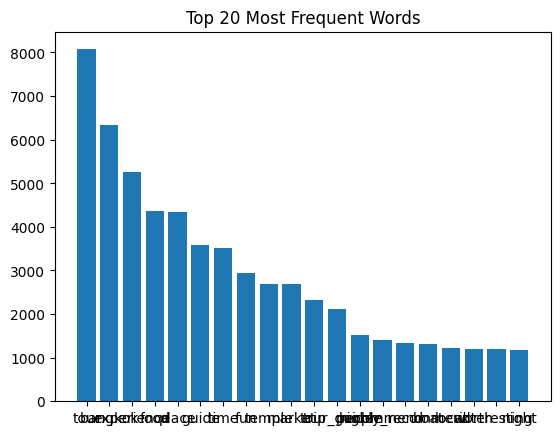

[('tour', 8077),
 ('bangkok', 6329),
 ('experience', 5249),
 ('food', 4352),
 ('place', 4351),
 ('guide', 3589),
 ('time', 3521),
 ('fun', 2945),
 ('temple', 2686),
 ('market', 2682),
 ('trip', 2313),
 ('tour_guide', 2124),
 ('people', 1514),
 ('recommend', 1411),
 ('highly_recommend', 1337),
 ('boat', 1311),
 ('local', 1227),
 ('worth', 1198),
 ('interesting', 1186),
 ('night', 1173)]

In [ ]:
# Combine all tokens into one list
all_tokens = [token for sublist in df_tl['tokens_bigrams'] for token in sublist]

# Convert to space-separated string for analysis
all_words = ' '.join(all_tokens)
bag_of_words_analysis(all_words)

In [ ]:
# TF-IDF Analysis
def tf_idf_analysis(texts, top_n=20):
    vectorizer = TfidfVectorizer(stop_words=list(final_stopwords))
    tfidf_matrix = vectorizer.fit_transform([texts])
    feature_array = np.array(vectorizer.get_feature_names_out())

    # Dictionary to keep track of words and their corresponding scores
    max_tfidf_dict = {}
    for i in range(tfidf_matrix.shape[0]):
        row = tfidf_matrix.getrow(i)
        for word, score in zip(row.indices, row.data):
            feature_word = feature_array[word]
            max_tfidf_dict[feature_word] = max(max_tfidf_dict.get(feature_word, 0), score)

    # Sort words by their score and get top n
    sorted_words = sorted(max_tfidf_dict.items(), key=lambda item: item[1], reverse=True)[:top_n]
    words, scores = zip(*sorted_words)

    return words, scores

# Combine all tokens (cleaned) into one string
all_tokens = [token for sublist in df_tl['tokens_bigrams'] for token in sublist]
all_words = ' '.join(all_tokens)

# Conduct TF-IDF analysis
top_words, top_scores = tf_idf_analysis(all_words)

# Print the top 20 common words
print("Top 20 common words and their TF-IDF scores:")
for word, score in zip(top_words, top_scores):
    print(f"{word}: {score:.4f}")

Top 20 common words and their TF-IDF scores:
tour: 0.4416
bangkok: 0.3461
experience: 0.2870
food: 0.2380
place: 0.2379
guide: 0.1962
time: 0.1925
fun: 0.1610
temple: 0.1469
market: 0.1466
trip: 0.1265
tour_guide: 0.1161
people: 0.0828
recommend: 0.0772
highly_recommend: 0.0731
boat: 0.0717
local: 0.0671
worth: 0.0655
interesting: 0.0648
night: 0.0641


LDA Training

Num Topics: 2, Coherence Score: 0.3944
Num Topics: 3, Coherence Score: 0.4061
Num Topics: 4, Coherence Score: 0.3956
Num Topics: 5, Coherence Score: 0.4097
Num Topics: 6, Coherence Score: 0.4200
Num Topics: 7, Coherence Score: 0.3961
Num Topics: 8, Coherence Score: 0.4073
Num Topics: 9, Coherence Score: 0.4427
Num Topics: 10, Coherence Score: 0.4091
Num Topics: 11, Coherence Score: 0.4460
Num Topics: 12, Coherence Score: 0.4686
Num Topics: 13, Coherence Score: 0.4515
Num Topics: 14, Coherence Score: 0.4731
Num Topics: 15, Coherence Score: 0.4508
Num Topics: 16, Coherence Score: 0.4372
Num Topics: 17, Coherence Score: 0.4190
Num Topics: 18, Coherence Score: 0.4344
Num Topics: 19, Coherence Score: 0.4320


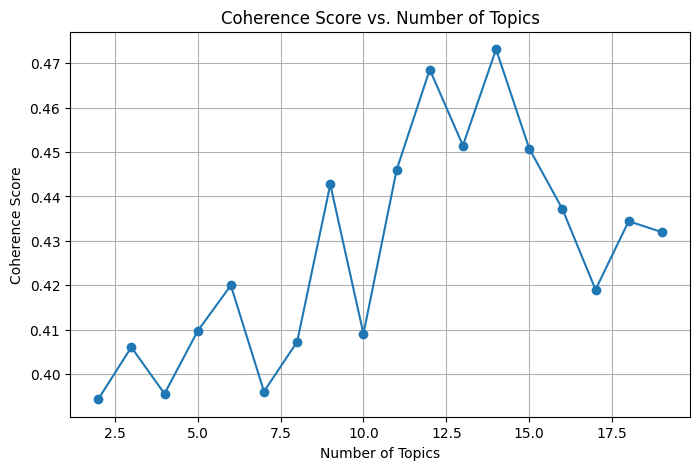

Optimal Number of Topics: 14


In [ ]:
#Coherence score by number of topics

tokenized_texts = df_tl['tokens_bigrams'].tolist()

dictionary_tl = Dictionary(df_tl['tokens_bigrams'])
dictionary_tl.filter_extremes(no_below=5, no_above=0.5)
corpus_tl = [dictionary_tl.doc2bow(text) for text in df_tl['tokens_bigrams']]

def compute_coherence_values(dictionary, corpus, texts, topic_range):
    coherence_scores = []
    for num_topics in topic_range:
        lda_model = gensim.models.LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics,
            random_state=42,
            passes=10,
            iterations=200
        )
        coherence_model = CoherenceModel(
            model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v'
        )
        coherence_score = coherence_model.get_coherence()
        coherence_scores.append(coherence_score)
        print(f"Num Topics: {num_topics}, Coherence Score: {coherence_score:.4f}")

    return coherence_scores

topic_range = range(2, 20)

coherence_scores = compute_coherence_values(dictionary_tl, corpus_tl, tokenized_texts, topic_range)

plt.figure(figsize=(8, 5))
plt.plot(topic_range, coherence_scores, marker='o', linestyle='-')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Score vs. Number of Topics")
plt.grid()
plt.show()

optimal_topic_num = topic_range[coherence_scores.index(max(coherence_scores))]
print(f"Optimal Number of Topics: {optimal_topic_num}")

In [ ]:
dictionary_tl = Dictionary(df_tl['tokens_bigrams'])
dictionary_tl.filter_extremes(no_below=5, no_above=0.5)
corpus_tl = [dictionary_tl.doc2bow(text) for text in df_tl['tokens_bigrams']]

#Train LDA model
lda_model_tl = LdaModel(
    corpus=corpus_tl,
    id2word=dictionary_tl,
    num_topics=12,
    random_state=42,
    passes=15,
    iterations=500,
    alpha='auto',
    eta='auto',
    minimum_probability=0.01
)

# Print output LDA topics with top 10 keywords
print("\n=== LDA Topics ===")
for topic_id, words in lda_model_tl.show_topics(num_topics=12, num_words=20, formatted=False):
    print(f"Topic {topic_id}: {[word for word, _ in words]}")


=== LDA Topics ===
Topic 0: ['place', 'shop', 'mall', 'shopping', 'price', 'restaurant', 'buy', 'street', 'market', 'find', 'everything', 'store', 'big', 'cheap', 'shopping_mall', 'food_court', 'food', 'floor', 'product', 'item']
Topic 1: ['boat', 'baht', 'pay', 'price', 'min', 'sea', 'seems', 'scam', 'driver', 'water', 'tourist_trap', 'bath', 'overpriced', 'expensive', 'hour', 'b', 'dirty', 'cost', 'transfer', 'ok']
Topic 2: ['class', 'dish', 'carving', 'rice', 'fee', 'cooking', 'ingredient', 'cooking_class', 'seafood', 'snake', 'definitely_come', 'market', 'simple', 'satisfied', 'cooked', 'mango_sticky', 'wat', 'n', 'morning', 'teacher']
Topic 3: ['pattaya', 'time', 'people', 'back', 'come', 'need', 'better', 'want', 'minute', 'ride', 'long', 'tourist', 'first', 'water', 'think', 'place', 'thing', 'always', 'dont', 'clean']
Topic 4: ['tour', 'bangkok', 'food', 'fun', 'guide', 'beach', 'tour_guide', 'night', 'highly_recommend', 'local', 'time', 'fantastic', 'took', 'tuk_tuk', 'experi

In [ ]:
dictionary_tl = Dictionary(df_tl['tokens_bigrams'])
dictionary_tl.filter_extremes(no_below=5, no_above=0.5)
corpus_tl = [dictionary_tl.doc2bow(text) for text in df_tl['tokens_bigrams']]

#Train LDA model
lda_model_tl = LdaModel(
    corpus=corpus_tl,
    id2word=dictionary_tl,
    num_topics=12,
    random_state=42,
    passes=10,
    iterations=200,
    alpha='auto',
    eta='auto',
    minimum_probability=0.01
)

# Print output LDA topics with top 10 keywords
print("\n=== LDA Topics ===")
for topic_id, words in lda_model_tl.show_topics(num_topics=12, num_words=20, formatted=False):
    print(f"Topic {topic_id}: {[word for word, _ in words]}")


=== LDA Topics ===
Topic 0: ['place', 'shop', 'mall', 'shopping', 'market', 'price', 'food', 'buy', 'restaurant', 'street', 'store', 'find', 'everything', 'cheap', 'food_court', 'big', 'shopping_mall', 'product', 'floor', 'tourist']
Topic 1: ['boat', 'baht', 'price', 'pay', 'hour', 'driver', 'taxi', 'min', 'water', 'sea', 'back', 'expensive', 'scam', 'tourist_trap', 'ride', 'seems', 'bath', 'cost', 'ok', 'stop']
Topic 2: ['class', 'dish', 'carving', 'rice', 'fee', 'cooking', 'seafood', 'market', 'ingredient', 'cooking_class', 'snake', 'morning', 'simple', 'cooked', 'mango_sticky', 'n', 'definitely_come', 'home', 'wat', 'eat']
Topic 3: ['pattaya', 'time', 'place', 'people', 'back', 'come', 'kid', 'family', 'staff', 'year', 'need', 'child', 'water_park', 'water', 'ride', 'better', 'service', 'think', 'always', 'use']
Topic 4: ['tour', 'bangkok', 'food', 'fun', 'guide', 'experience', 'beach', 'tour_guide', 'night', 'time', 'highly_recommend', 'fantastic', 'local', 'tuk_tuk', 'took', 'rec

Evaluation

In [ ]:
#Coherence score
coherence_model_lda = CoherenceModel(
    model=lda_model_tl, texts=df_tl['tokens_bigrams'], dictionary=dictionary_tl, coherence='c_v'
)
coherence_lda = coherence_model_lda.get_coherence()

print(f"LDA Coherence Score: {coherence_lda:.3f}")

LDA Coherence Score: 0.478


In [ ]:
# LDA diversity
def calculate_lda_topic_diversity(lda_model, top_n_words=20):
    topics = lda_model.show_topics(num_topics=lda_model.num_topics, num_words=top_n_words, formatted=False)
    unique_words = set()
    for topic in topics:
        unique_words.update([word for word, _ in topic[1]])
    num_unique_words = len(unique_words)
    total_words_considered = top_n_words * lda_model.num_topics
    print(f"Number of unique words: {num_unique_words}")
    print(f"Total words considered: {total_words_considered}")
    return num_unique_words / total_words_considered

lda_topic_diversity = calculate_lda_topic_diversity(lda_model_tl)

print(f"LDA Topic Diversity Score: {lda_topic_diversity:.3f}")

Number of unique words: 204
Total words considered: 240
LDA Topic Diversity Score: 0.850


In [ ]:
import pyLDAvis.gensim_models

dictionary_tweet = corpora.Dictionary(df_tl['tokens_bigrams'])
dictionary_tweet.filter_extremes(no_below=5, no_above=0.5)
corpus_tweet = [dictionary_tweet.doc2bow(text) for text in df_tl['tokens_bigrams']]

num_topics = 12
lda_model = gensim.models.LdaModel(
    corpus=corpus_tweet,
    id2word=dictionary_tweet,
    num_topics=num_topics,
    random_state=42,
    passes=10,
    iterations=200
)
pyLDAvis.enable_notebook(local=True)

vis = pyLDAvis.gensim_models.prepare(lda_model, corpus_tweet, dictionary_tweet)

vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.167168  0.125626       1        1  19.117598
11    -0.170568  0.035232       2        1  11.802689
8      0.190576  0.134812       3        1  11.219649
3     -0.137356  0.080073       4        1  10.410169
0     -0.049085  0.064985       5        1  10.386728
9     -0.005445 -0.077640       6        1   7.187898
5      0.144843  0.071932       7        1   6.277848
10    -0.134476  0.059507       8        1   6.224674
6      0.003972 -0.050965       9        1   5.691435
1     -0.212676  0.053278      10        1   5.528393
2      0.209007 -0.096580      11        1   3.886656
7     -0.005959 -0.400260      12        1   2.266262, topic_info=            Term         Freq        Total Category  logprob  loglift
20          tour  7048.000000  7048.000000  Default  30.0000  30.0000
79        temple  2444.000000  2444.000000  Default  29.0000  29.0000
164         food  4258.000000  4258.000000  Default  28.0000  28.0000
40    experience  5127.000000  5127.000000  Default  27.0000  27.0000
114       market  2452.000000  2452.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
2135      camera    46.781170    86.995639  Topic12  -5.2918   3.1667
273         cool    62.377310   455.076015  Topic12  -5.0040   1.7998
3175        calm    47.345691    93.901570  Topic12  -5.2798   3.1023
29        lovely    64.289613   757.938387  Topic12  -4.9738   1.3198
290        along    50.157043   432.610247  Topic12  -5.2221   1.6324

[759 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
336      12  0.987532     accompanied
727       7  0.973470          action
3495     12  0.990966          advice
2389      4  0.985185  airconditioned
3416      4  0.700918         airport
...     ...       ...             ...
1741      4  0.984473           young
154      11  0.968722           yummy
486       4  0.931286            zone
486      12  0.059444            zone
3709      2  0.991256             zoo

[1600 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 12, 9, 4, 1, 10, 6, 11, 7, 2, 3, 8])

### Negative-Focused

In [ ]:
df_hanoi_sen = pd.read_csv('hanoi_sentiment.csv')
df_danang_sen = pd.read_csv('danang_sentiment.csv')

df_vn_sen = pd.concat([df_hanoi_sen, df_danang_sen], ignore_index=True)

In [ ]:
df_vn_nn = df_vn_sen[df_vn_sen['rating'].isin([1, 2, 3])].reset_index(drop=True)

In [ ]:
df_bangkok_sen = pd.read_csv('bangkok_sentiment.csv')
df_pattaya_sen = pd.read_csv('pattaya_sentiment.csv')

df_tl_sen = pd.concat([df_bangkok_sen, df_pattaya_sen], ignore_index=True)

In [ ]:
df_tl_nn = df_tl_sen[df_tl_sen['rating'].isin([1, 2, 3])].reset_index(drop=True)

**VN NN Topics**

In [ ]:
#Tokenize and reclean

nltk_stopwords = set(stopwords.words('english'))
custom_stopwords = {'u', 'hanoi', 'vietnam', 'really', 'would', 'also', 'made', 'well', 'lot', 'great', 'amazing', 'good', 'best', 'nice', 'much', 'excellent', 'fun', 'beautiful', 'wonderful', 'fantastic', 'one', 'thank', 'visit', 'go', 'get', 'day', 'perfect', 'went', 'take'}
final_stopwords = nltk_stopwords.union(custom_stopwords)

def tokenize_text(text):
    words = word_tokenize(str(text))
    return [word for word in words if word not in final_stopwords]

df_vn_nn['tokens'] = df_vn_nn['processed_text'].apply(tokenize_text)

# Build bigram model
bigram_model = Phrases(df_vn_nn['tokens'], min_count=5, threshold=5)  # tweak these for sensitivity
bigram_phraser = Phraser(bigram_model)

# Apply bigram transformation
df_vn_nn['tokens_bigrams'] = df_vn_nn['tokens'].apply(lambda x: bigram_phraser[x])

Num Topics: 2, Coherence Score: 0.3054
Num Topics: 3, Coherence Score: 0.3315
Num Topics: 4, Coherence Score: 0.2685
Num Topics: 5, Coherence Score: 0.3274
Num Topics: 6, Coherence Score: 0.3383
Num Topics: 7, Coherence Score: 0.3319
Num Topics: 8, Coherence Score: 0.3331
Num Topics: 9, Coherence Score: 0.3042
Num Topics: 10, Coherence Score: 0.2993
Num Topics: 11, Coherence Score: 0.3109
Num Topics: 12, Coherence Score: 0.3083
Num Topics: 13, Coherence Score: 0.3250
Num Topics: 14, Coherence Score: 0.2881
Num Topics: 15, Coherence Score: 0.2772
Num Topics: 16, Coherence Score: 0.2743
Num Topics: 17, Coherence Score: 0.2932
Num Topics: 18, Coherence Score: 0.3010
Num Topics: 19, Coherence Score: 0.2813


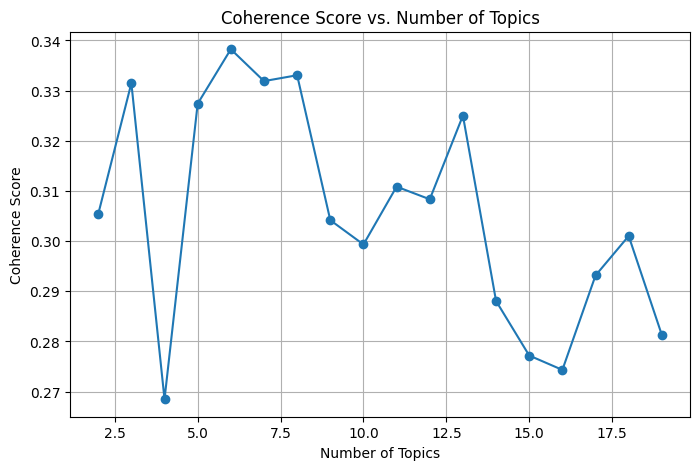

Optimal Number of Topics: 6


In [ ]:
#Coherence score by number of topics

tokenized_texts = df_vn_nn['tokens_bigrams'].tolist()

dictionary_vn_nn = Dictionary(df_vn_nn['tokens_bigrams'])
dictionary_vn_nn.filter_extremes(no_below=5, no_above=0.5)
corpus_vn_nn = [dictionary_vn_nn.doc2bow(text) for text in df_vn_nn['tokens_bigrams']]

def compute_coherence_values(dictionary, corpus, texts, topic_range):
    coherence_scores = []
    for num_topics in topic_range:
        lda_model = gensim.models.LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics,
            random_state=42,
            passes=10,
            iterations=200
        )
        coherence_model = CoherenceModel(
            model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v'
        )
        coherence_score = coherence_model.get_coherence()
        coherence_scores.append(coherence_score)
        print(f"Num Topics: {num_topics}, Coherence Score: {coherence_score:.4f}")

    return coherence_scores

topic_range = range(2, 20)

coherence_scores = compute_coherence_values(dictionary_vn_nn, corpus_vn_nn, tokenized_texts, topic_range)

plt.figure(figsize=(8, 5))
plt.plot(topic_range, coherence_scores, marker='o', linestyle='-')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Score vs. Number of Topics")
plt.grid()
plt.show()

optimal_topic_num = topic_range[coherence_scores.index(max(coherence_scores))]
print(f"Optimal Number of Topics: {optimal_topic_num}")

In [ ]:
dictionary_vn_nn = Dictionary(df_vn_nn['tokens_bigrams'])
dictionary_vn_nn.filter_extremes(no_below=5, no_above=0.5)
corpus_vn_nn = [dictionary_vn_nn.doc2bow(text) for text in df_vn_nn['tokens_bigrams']]

#Train LDA model
lda_model_vn_nn = LdaModel(
    corpus=corpus_vn_nn,
    id2word=dictionary_vn_nn,
    num_topics=6,
    random_state=42,
    passes=15,
    iterations=500,
    alpha='auto',
    eta='auto',
    minimum_probability=0.01
)

# Print output LDA topics with top 20 keywords
print("\n=== LDA Topics ===")
for topic_id, words in lda_model_vn_nn.show_topics(num_topics=6, num_words=20, formatted=False):
    print(f"Topic {topic_id}: {[word for word, _ in words]}")


=== LDA Topics ===
Topic 0: ['time', 'food', 'experience', 'place', 'cable_car', 'people', 'ride', 'guide', 'show', 'even', 'restaurant', 'ticket', 'many', 'long', 'better', 'recommend', 'little', 'top', 'minute', 'weather']
Topic 1: ['train', 'street', 'cafe', 'train_street', 'drink', 'time', 'tourist', 'experience', 'people', 'police', 'local', 'track', 'enter', 'coffee', 'shop', 'scam', 'away', 'place', 'let', 'even']
Topic 2: ['tour', 'place', 'boat', 'time', 'back', 'experience', 'people', 'trip', 'could', 'got', 'show', 'like', 'cruise', 'bridge', 'tourist', 'guide', 'room', 'even', 'first', 'see']
Topic 3: ['cable_car', 'ride', 'see', 'ticket', 'park', 'time', 'view', 'hill', 'bridge', 'worth', 'theme_park', 'place', 'like', 'ba_na', 'many', 'kid', 'expensive', 'top', 'golden_bridge', 'people']
Topic 4: ['interesting', 'bridge', 'massage', 'see', 'better', 'museum', 'tourist', 'like', 'people', 'place', 'restaurant', 'time', 'history', 'worth', 'city', 'vietnamese', 'bit', 'man

In [ ]:
#Coherence score
coherence_model_lda = CoherenceModel(
    model=lda_model_vn_nn, texts=df_vn_nn['tokens_bigrams'], dictionary=dictionary_vn_nn, coherence='c_v'
)
coherence_lda = coherence_model_lda.get_coherence()

print(f"LDA Coherence Score: {coherence_lda:.3f}")

LDA Coherence Score: 0.375


In [ ]:
# LDA diversity
def calculate_lda_topic_diversity(lda_model_vn, top_n_words=20):
    topics = lda_model_vn.show_topics(num_topics=lda_model_vn.num_topics, num_words=top_n_words, formatted=False)
    unique_words = set()
    for topic in topics:
        unique_words.update([word for word, _ in topic[1]])
    return len(unique_words) / (top_n_words * lda_model_vn.num_topics)

lda_topic_diversity = calculate_lda_topic_diversity(lda_model_vn_nn)

print(f"LDA Topic Diversity Score: {lda_topic_diversity:.3f}")

LDA Topic Diversity Score: 0.583


**TL NN Topics**

In [ ]:
#Tokenize and reclean

nltk_stopwords = set(stopwords.words('english'))
custom_stopwords = {'great', 'good', 'amazing', 'also', 'nice', 'one', 'lot', 'u', 'get', 'go', 'day', 'best', 'really', 'many', 'thailand', 'thai', 'like', 'excellent', 'much', 'see', 'visit', 'well', 'around', 'take', 'way', 'would', 'went', 'city', 'beautiful', 'made', 'must'}
final_stopwords = nltk_stopwords.union(custom_stopwords)

def tokenize_text(text):
    words = word_tokenize(str(text))
    return [word for word in words if word not in final_stopwords]

# Ensure processed_text is string and fill potential NaNs before tokenization
df_tl_nn['processed_text'] = df_tl_nn['processed_text'].astype(str).fillna('')
df_tl_nn['tokens'] = df_tl_nn['processed_text'].apply(tokenize_text)

# Build bigram model
bigram_model = Phrases(df_tl_nn['tokens'], min_count=5, threshold=5)  # tweak these for sensitivity
bigram_phraser = Phraser(bigram_model)

# Apply bigram transformation
df_tl_nn['tokens_bigrams'] = df_tl_nn['tokens'].apply(lambda x: bigram_phraser[x])

Num Topics: 2, Coherence Score: 0.3089
Num Topics: 3, Coherence Score: 0.3251
Num Topics: 4, Coherence Score: 0.3452
Num Topics: 5, Coherence Score: 0.3360
Num Topics: 6, Coherence Score: 0.3191
Num Topics: 7, Coherence Score: 0.3257
Num Topics: 8, Coherence Score: 0.3072
Num Topics: 9, Coherence Score: 0.3060
Num Topics: 10, Coherence Score: 0.3107
Num Topics: 11, Coherence Score: 0.3157
Num Topics: 12, Coherence Score: 0.3151
Num Topics: 13, Coherence Score: 0.3134
Num Topics: 14, Coherence Score: 0.2907
Num Topics: 15, Coherence Score: 0.2995
Num Topics: 16, Coherence Score: 0.2917
Num Topics: 17, Coherence Score: 0.2941
Num Topics: 18, Coherence Score: 0.3072
Num Topics: 19, Coherence Score: 0.3161


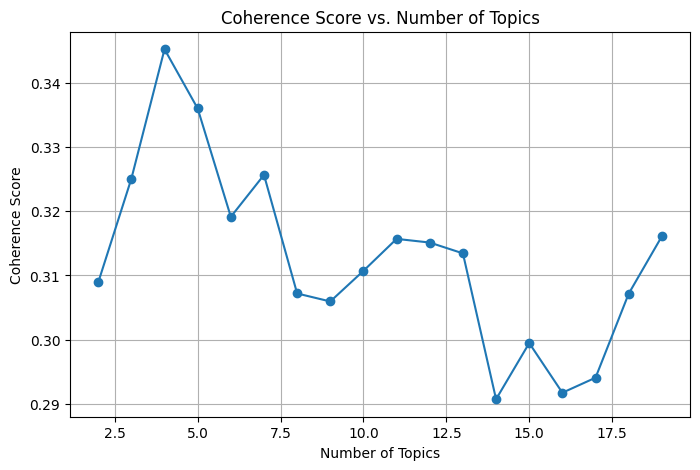

Optimal Number of Topics: 4


In [ ]:
#Coherence score by number of topics

tokenized_texts = df_tl_nn['tokens_bigrams'].tolist()

dictionary_tl_nn = Dictionary(df_tl_nn['tokens_bigrams'])
dictionary_tl_nn.filter_extremes(no_below=5, no_above=0.5)
corpus_tl_nn = [dictionary_tl_nn.doc2bow(text) for text in df_tl_nn['tokens_bigrams']]

def compute_coherence_values(dictionary, corpus, texts, topic_range):
    coherence_scores = []
    for num_topics in topic_range:
        lda_model = gensim.models.LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics,
            random_state=42,
            passes=10,
            iterations=200
        )
        coherence_model = CoherenceModel(
            model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v'
        )
        coherence_score = coherence_model.get_coherence()
        coherence_scores.append(coherence_score)
        print(f"Num Topics: {num_topics}, Coherence Score: {coherence_score:.4f}")

    return coherence_scores

topic_range = range(2, 20)

coherence_scores = compute_coherence_values(dictionary_tl_nn, corpus_tl_nn, tokenized_texts, topic_range)

plt.figure(figsize=(8, 5))
plt.plot(topic_range, coherence_scores, marker='o', linestyle='-')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Score vs. Number of Topics")
plt.grid()
plt.show()

optimal_topic_num = topic_range[coherence_scores.index(max(coherence_scores))]
print(f"Optimal Number of Topics: {optimal_topic_num}")

In [ ]:
dictionary_tl_nn = Dictionary(df_tl_nn['tokens_bigrams'])
dictionary_tl_nn.filter_extremes(no_below=5, no_above=0.5)
corpus_tl_nn = [dictionary_tl_nn.doc2bow(text) for text in df_tl_nn['tokens_bigrams']]

#Train LDA model
lda_model_tl_nn = LdaModel(
    corpus=corpus_tl_nn,
    id2word=dictionary_tl_nn,
    num_topics=4,
    random_state=42,
    passes=15,
    iterations=500,
    alpha='auto',
    eta='auto',
    minimum_probability=0.01
)

# Print output LDA topics with top 20 keywords
print("\n=== LDA Topics ===")
for topic_id, words in lda_model_tl_nn.show_topics(num_topics=4, num_words=20, formatted=False):
    print(f"Topic {topic_id}: {[word for word, _ in words]}")


=== LDA Topics ===
Topic 0: ['tour', 'boat', 'time', 'guide', 'market', 'place', 'floating_market', 'hour', 'temple', 'tourist', 'experience', 'people', 'elephant', 'bangkok', 'back', 'train', 'trip', 'ride', 'minute', 'worth']
Topic 1: ['place', 'market', 'price', 'tourist', 'bangkok', 'boat', 'food', 'shop', 'beach', 'people', 'mall', 'time', 'experience', 'street', 'restaurant', 'better', 'stall', 'find', 'even', 'crowded']
Topic 2: ['time', 'bangkok', 'ticket', 'price', 'scam', 'baht', 'staff', 'tiger', 'experience', 'place', 'park', 'food', 'floating_market', 'people', 'money', 'taxi', 'tourist', 'got', 'pay', 'trip']
Topic 3: ['animal', 'place', 'price', 'baht', 'show', 'zoo', 'experience', 'garden', 'expensive', 'shop', 'pay', 'store', 'elephant', 'tourist', 'money', 'area', 'people', 'restaurant', 'time', 'need']
